In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)


/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
INFO:purepyindi2.transports:Connected to localhost:7624


18.389524275269295 arcsec
0.08599262769878883


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 100
cam.set_roi(560, 890, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

In [5]:
fsm = ImageStream('fsm')

In [6]:
fsm.write(v_bias)

In [2]:
amp = 0.5*as_per_lamD

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 37
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec)
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i])

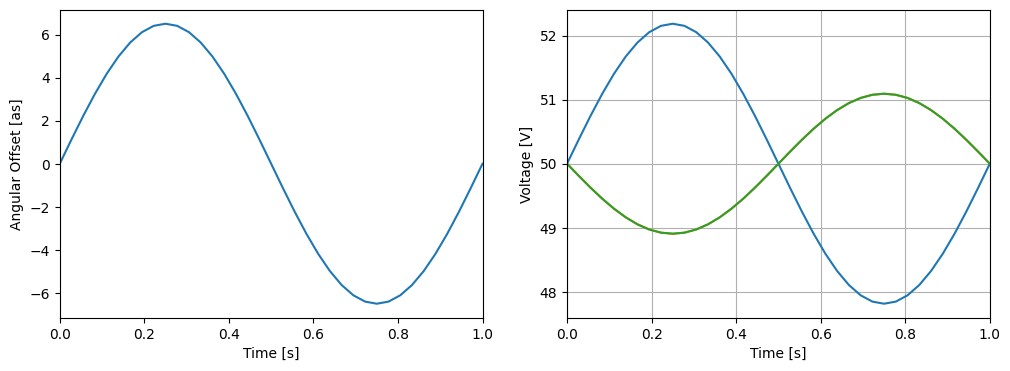

In [3]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(times, wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
# plt.grid()
# plt.show()

plt.subplot(122)
plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

# plt.subplots_adjust(wspace=10.5)

In [4]:
freq = 1 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    start = time.time()
    while i<Nsamps+1:
        if i==Nsamps-1:
            i = 0
        print(i, volt_commands[i].T)
        time.sleep(1)
        i += 1
except KeyboardInterrupt:
    end = time.time()
    print('FSM modulation stopped!')
    # fsm.write(v_bias)
    time.sleep(0.25)
print(start, end)

Modulating FSM ...
0 [[50. 50. 50.]]
1 [[50.37921998 49.81039001 49.81039001]]
2 [[50.74691756 49.62654122 49.62654122]]
3 [[51.09192043 49.45403979 49.45403979]]
4 [[51.40374584 49.29812708 49.29812708]]
5 [[51.67291915 49.16354042 49.16354042]]
6 [[51.89126166 49.05436917 49.05436917]]
7 [[52.05213914 48.97393043 48.97393043]]
8 [[52.15066341 48.9246683  48.9246683 ]]
9 [[52.18384086 48.90807957 48.90807957]]
10 [[52.15066341 48.9246683  48.9246683 ]]
11 [[52.05213914 48.97393043 48.97393043]]
12 [[51.89126166 49.05436917 49.05436917]]
13 [[51.67291915 49.16354042 49.16354042]]
14 [[51.40374584 49.29812708 49.29812708]]
15 [[51.09192043 49.45403979 49.45403979]]
16 [[50.74691756 49.62654122 49.62654122]]
FSM modulation stopped!
1733512272.508732 1733512288.904711


In [12]:
freq = 1 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    start = time.time()
    while i<Nsamps+1:
        if i==Nsamps-1:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
except KeyboardInterrupt:
    end = time.time()
    print('FSM modulation stopped!')
    fsm.write(v_bias)
    time.sleep(0.25)
print(start, end)

Modulating FSM ...
FSM modulation stopped!
1732580721.483729 1732580728.9001982


In [ ]:
fsm.write(0*v_bias)

In [ ]:
start = time.time()
end = start + t_total.to_value(u.s)
count = 0
frames = []
cam.Nframes = Nexp_per_frame
adcs = []
while time.time()<end:
    print(f"Capturing frame {count+1:d}. Time = {time.time()-start:.3f}s", end='')
    print("\r", end="")
    frames.append(cam.snap())
    adcs.append(np.array([client0['fsmCtrl.adc_1.current'], client0['fsmCtrl.adc_2.current'], client0['fsmCtrl.adc_3.current']]))
    count += 1
    time.sleep(1/freq.to_value(u.Hz) - cam.Nframes/fps)

frames = np.array(frames)

data = {
    'AMP':amp, 
    'FRAMES':frames,
    'ADCS':adcs, 
    'FREQ':freq.to_value(u.Hz),
    'EXPTIME':exp_time,
    'NEXPS':Nexp_per_frame, 
    'FPS':fps, 
    'TIME':t_total.to_value(u.s),
}
utils.save_pickle(f'data/drift/{today}_fsm_sin_mod.pkl', data)

8